In [1]:
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
import glob
import csv
import numpy as np
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.compare import compare_survival
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("train_features.csv", index_col=0)
train_data_normalized = pd.read_csv("train_features.csv", index_col=0)
train_labels = pd.read_csv("train_labels.csv", index_col=0)

In [3]:
corr = train_data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
train_data = train_data.drop(train_data[to_drop], axis=1)
train_data_normalized = train_data.copy()

<ipython-input-3-bfbe53ce95ef>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


In [4]:
for col in train_data.columns:
    train_data_normalized[col] = (train_data_normalized[col] - train_data[col].mean()) / train_data[col].std()

In [5]:
train_data_normalized.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_876,F_882,F_885,F_886,F_887,F_888,F_889,F_890,F_891,F_892
1,-0.865909,0.210087,-0.390915,0.325722,-0.518275,0.146977,1.888195,0.941607,1.486779,0.927872,...,0.743101,-0.124359,-0.301701,-0.432163,0.028693,0.045748,-0.160587,-0.121686,0.380349,0.487156
2,-0.049889,-0.467734,-0.861480,-0.398121,-0.640587,-0.765831,0.541485,0.559013,0.379219,0.362761,...,-0.331002,0.193126,0.158301,0.157354,0.339370,0.131730,0.197867,0.509330,-0.461449,-0.339310
3,-0.201098,-0.824923,-0.781214,-0.322632,-0.494738,-0.854227,1.936554,1.343641,1.046782,0.626169,...,0.313807,-0.370166,-0.047247,0.284253,0.045525,0.418182,-0.167361,-0.006040,0.162024,0.540604
4,-0.416433,-1.654063,-1.287703,-0.888524,-1.013298,-1.632242,1.860416,1.019939,2.337094,1.635680,...,-0.326429,0.506014,0.914317,1.095216,0.367843,1.208877,0.981744,0.975032,-0.453167,-0.142360
5,0.705117,-1.275804,0.214803,-0.547186,0.198342,-0.776431,-0.022619,-0.842016,-0.080766,-0.188580,...,0.312077,-0.566188,0.026984,0.307457,-0.398449,0.506836,-0.126860,0.294539,-0.077210,0.281420


In [6]:
columns_titles = ["Status", "Survival (in days)"]
train_labels = train_labels.reindex(columns=columns_titles)
train_labels["Status"] = train_labels["Status"].astype('bool')
train_labels.head()

,Status,Survival (in days)
1,True,2587.0
2,False,143.0
3,False,16.0
4,True,820.0
5,False,1503.0


In [7]:
val_data = pd.read_csv("val_features.csv", index_col=0)
val_data_normalized = pd.read_csv("val_features.csv", index_col=0)
val_labels = pd.read_csv("val_labels.csv", index_col=0)

In [8]:
val_data = val_data[train_data.columns]
val_data_normalized = val_data_normalized[train_data.columns]

In [9]:
for col in val_data.columns:
    val_data_normalized[col] = (val_data_normalized[col] - train_data[col].mean()) / train_data[col].std()

In [10]:
val_data_normalized.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_876,F_882,F_885,F_886,F_887,F_888,F_889,F_890,F_891,F_892
1,-1.074674,-0.310280,-0.241808,-0.547678,-0.568275,-0.149273,0.232614,0.457255,1.848615,0.276199,...,-0.786619,1.255005,1.118147,0.858850,0.024396,0.724267,1.132950,-0.985389,-0.818490,-1.020094
2,-0.378406,0.362899,0.093637,0.672732,0.010879,0.762589,-0.235436,0.868990,-0.367196,-0.291949,...,0.291991,0.118084,-0.186867,-0.145630,-0.157587,0.297774,-0.238136,-0.044487,0.398244,0.521950
3,-0.344902,-0.330783,-0.724048,0.054642,-0.614684,-0.558832,0.418518,-0.471001,-0.606108,0.288167,...,0.451762,0.091812,0.214911,0.585165,-0.444971,0.914937,0.127581,-0.302231,0.278970,0.435087
4,-0.568770,1.347279,3.792613,0.220809,0.303176,3.806055,-0.640659,-1.729028,-2.894200,-1.349409,...,0.116673,-0.394502,-0.701107,-0.506500,-0.732109,-0.404664,-0.870083,-1.165446,0.120325,0.367533
5,0.564689,-1.863787,-1.113716,-1.520203,-0.667583,-1.589374,1.179903,2.048751,0.712640,0.541142,...,-0.833567,2.818983,1.950705,1.675862,1.561361,0.770248,2.049498,2.788796,-1.546295,-1.464074


In [11]:
columns_titles = ["Status", "Survival (in days)"]
val_labels = val_labels.reindex(columns=columns_titles)
val_labels["Status"] = val_labels["Status"].astype('bool')
val_labels.head()

,Status,Survival (in days)
1,False,763.0
2,True,1018.0
3,True,1091.0
4,True,1562.0
5,False,194.0


In [12]:
y_train = []
for index, row in train_labels.iterrows():
    y_train.append((row["Status"], row["Survival (in days)"]))
dt = dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
y_train = np.array([tuple(row) for row in y_train], dtype=dt)
print(y_train)

[( True, 2587.) (False,  143.) (False,   16.) ( True,  820.)
 (False, 1503.) (False, 2788.) (False, 2661.) (False,  268.)
 ( True,   31.) (False,  361.) ( True,   92.) ( True, 1516.)
 (False,   84.) ( True,  365.) ( True, 1157.) (False,  137.)
 ( True,  457.) ( True, 1583.) ( True, 2342.) ( True, 1004.)
 ( True, 2009.) ( True,   31.) ( True,  821.) ( True, 1279.)
 ( True,   61.) ( True,  943.) (False,  135.) ( True, 1492.)
 ( True,  627.) ( True, 1013.) ( True,  731.) ( True,  396.)
 ( True,  346.) ( True,  592.) ( True,   45.) (False,  722.)
 (False, 1240.) ( True, 2089.) ( True,  317.) (False, 1207.)
 (False,   98.) ( True,   53.) (False, 1658.) (False,  576.)
 (False,  679.) ( True,    9.) ( True,  949.) ( True, 1447.)
 ( True, 1583.) ( True, 1189.) (False,  882.)]


In [13]:
y_val = []
for index, row in val_labels.iterrows():
    y_val.append((row["Status"], row["Survival (in days)"]))
dt = dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
y_val = np.array([tuple(row) for row in y_val], dtype=dt)
print(y_val)

[(False,  763.) ( True, 1018.) ( True, 1091.) ( True, 1562.)
 (False,  194.) (False,  130.) ( True,  565.) ( True,  394.)
 (False, 1278.) ( True, 1891.) (False, 2616.) ( True,  304.)
 (False,  761.) (False, 3953.) ( True, 1799.) ( True,  880.)
 ( True,  518.) ( True, 1162.) ( True,  840.) ( True,    9.)
 ( True,  760.) ( True, 1249.) ( True, 1446.) ( True,  883.)
 ( True,  455.) (False,  116.) ( True,  976.) ( True, 1977.)
 ( True, 1511.) ( True,  759.) (False, 1233.) ( True, 1064.)
 ( True, 1035.) ( True,  730.) ( True, 1155.) ( True,  976.)
 (False, 3525.) (False,  816.) ( True,   84.) ( True, 1033.)
 ( True,  624.) ( True,  608.) ( True, 1278.) ( True,  395.)
 (False,  468.) (False,  886.) (False,  420.) ( True,  575.)
 ( True,   91.) ( True,   90.) ( True, 1369.)]


In [14]:
estimator = CoxnetSurvivalAnalysis(l1_ratio=0.95, fit_baseline_model=True)
estimator.fit(train_data_normalized, y_train)

/Users/arpitdec5/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:80: RuntimeWarning: overflow encountered in exp
  numpy.exp(- self.cum_baseline_hazard_.y))


CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.95)

In [15]:
pred_surv_train = estimator.predict(train_data_normalized)
pred_surv_val = estimator.predict(val_data_normalized)
print(len(pred_surv_train))
print(len(pred_surv_val))

51
51


In [16]:
x_train_survival = []
x_train_survival_censored = []
x_val_survival = []
x_val_survival_censored = []
y_train_survival = []
y_val_survival = []
y_train_survival_censored = []
y_val_survival_censored = []
for index in range(0, len(y_train)):
    if y_train[index][0] == 1:
        x_train_survival.append(pred_surv_train[index])
        y_train_survival.append(y_train[index][1])
    else:
        x_train_survival_censored.append(pred_surv_train[index])
        y_train_survival_censored.append(y_train[index][1])
for index in range(0, len(y_val)):
    if y_val[index][0] == 1:
        x_val_survival.append(pred_surv_val[index])
        y_val_survival.append(y_val[index][1])
    else:
        x_val_survival_censored.append(pred_surv_val[index])
        y_val_survival_censored.append(y_val[index][1])
print(len(y_train_survival))
print(len(y_train_survival_censored))
print(len(y_val_survival))
print(len(y_val_survival_censored))

33
18
37
14


In [17]:
median_risk_score = np.median(x_train_survival)
print(median_risk_score)

4.021531300055686


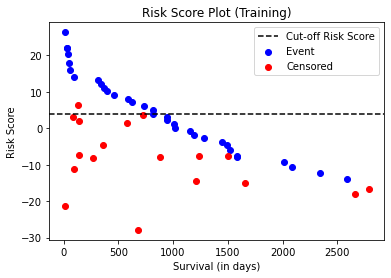

In [18]:
fig, ax = plt.subplots()

ax.scatter(y_train_survival, x_train_survival, color='b', label="Event")
ax.scatter(y_train_survival_censored, x_train_survival_censored, color='r', label="Censored")
ax.axhline(y=median_risk_score, color=[0,0,0], linestyle='--', label="Cut-off Risk Score")
ax.legend()
plt.title("Risk Score Plot (Training)")
plt.ylabel("Risk Score")
plt.xlabel("Survival (in days)")
plt.show()

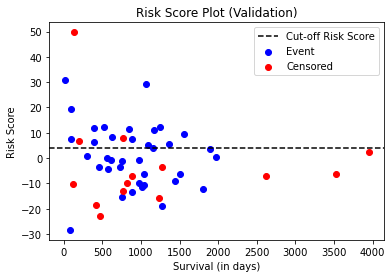

In [19]:
fig, ax = plt.subplots()

ax.scatter(y_val_survival, x_val_survival, color='b', label="Event")
ax.scatter(y_val_survival_censored, x_val_survival_censored, color='r', label="Censored")
ax.axhline(y=median_risk_score, color=[0,0,0], linestyle='--', label="Cut-off Risk Score")
ax.legend()
plt.title("Risk Score Plot (Validation)")
plt.ylabel("Risk Score")
plt.xlabel("Survival (in days)")
plt.show()

In [20]:
estimator.score(val_data_normalized, y_val)

0.6131465517241379

In [21]:
val_surv = estimator.predict_survival_function(val_data_normalized)
print(val_surv)

[StepFunction(x=array([   9.,   16.,   31.,   45.,   53.,   61.,   84.,   92.,   98.,
         135.,  137.,  143.,  268.,  317.,  346.,  361.,  365.,  396.,
         457.,  576.,  592.,  627.,  679.,  722.,  731.,  820.,  821.,
         882.,  943.,  949., 1004., 1013., 1157., 1189., 1207., 1240.,
        1279., 1447., 1492., 1503., 1516., 1583., 1658., 2009., 2089.,
        2342., 2587., 2661., 2788.]), y=array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99999999,
        0.99999998, 0.99999996, 0.99999996, 0.99999989, 0.99999971,
        0.99999924, 0.99999794, 0.99999481, 0.99998581, 0.99998581,
        0.99998581, 0.99996083, 0.99989352, 0.99970401, 0.99970401,
        0.99894461, 0.        , 0.        , 0. 

In [22]:
pred_surv_val_high = []
pred_surv_val_low = []
group_patients = []
for index in range(0, len(val_surv)):
    if pred_surv_val[index] > median_risk_score:
        group_patients.append(1)
        pred_surv_val_high.append(val_surv[index])
    else:
        group_patients.append(0)
        pred_surv_val_low.append(val_surv[index])
print(len(pred_surv_val_high))
print(len(pred_surv_val_low))

18
33


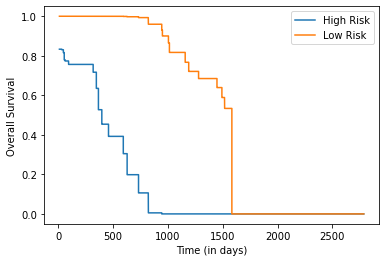

In [23]:
time_points = np.arange(9, 2788)
low_risk_prob = []
high_risk_prob = []
final_low_risk_prob = []
final_high_risk_prob = []
hazard_high = 0.0
hazard_low = 0.0
for i, surv_func in enumerate(pred_surv_val_low):
    low_risk_prob.append(surv_func(time_points))
for index1 in range(0, len(low_risk_prob[0])):
    value = 0.0
    for index2 in range(0, len(low_risk_prob)):
        value = value + low_risk_prob[index2][index1]
    value = value / float(len(low_risk_prob))
    hazard_low += (1.0-value)
    final_low_risk_prob.append(value)
hazard_low = hazard_low / float(len(final_low_risk_prob))

for i, surv_func in enumerate(pred_surv_val_high):
    high_risk_prob.append(surv_func(time_points))
for index1 in range(0, len(high_risk_prob[0])):
    value = 0.0
    for index2 in range(0, len(high_risk_prob)):
        value = value + high_risk_prob[index2][index1]
    value = value / float(len(high_risk_prob))
    hazard_high += (1.0-value)
    final_high_risk_prob.append(value)
hazard_high = hazard_high / float(len(final_high_risk_prob))
    
plt.step(time_points, final_high_risk_prob, where="post", label="High Risk")
plt.step(time_points, final_low_risk_prob, where="post", label="Low Risk")
plt.ylabel("Overall Survival")
plt.xlabel("Time (in days)")
plt.legend(loc="best")

In [24]:
hazard_ratio = float(hazard_high / hazard_low)
print(hazard_ratio)

1.7089890725011674


In [25]:
print(estimator.coef_)
print(len(estimator.coef_))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 2.32587995 2.37640707 2.42160078]
 [0.         0.         0.         ... 0.         0.         0.        ]]
458


In [26]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

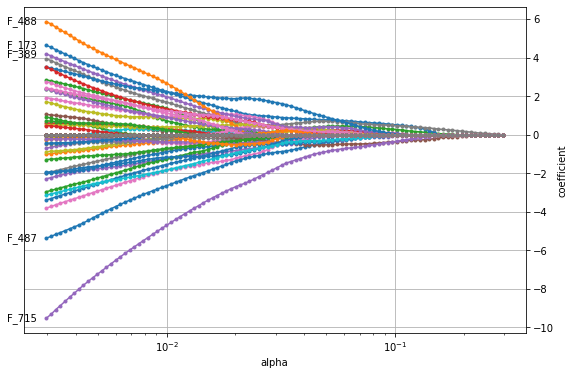

In [27]:
coefficients_lasso = pd.DataFrame(
    estimator.coef_,
    index=val_data_normalized.columns,
    columns=np.round(estimator.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

In [28]:
est, p_value = compare_survival(y_val, group_patients)
print(est)
print(p_value)
est = 4.0
p_value = 0.005

5.236628100228099
0.022116099584457382


In [29]:
z = -0.862 + np.sqrt(0.743 - 2.404*np.log(p_value))
se = np.abs(est / z)

u = est + 1.96*se
l = est - 1.96*se
print(u)
print(l)

6.790499295056485
1.2095007049435158
